<H3>PRI 2023/24: first project delivery</H3>

**GROUP 11**
- Francisco Martins, 99068
- Tunahan Güneş, 108108
- Sebastian Weidinger, 111612

<H3>Part I: demo of facilities</H3>

In [ ]:
import os
import json
from nltk.tokenize import sent_tokenize
import re

In [ ]:
def preprocess_article(text: str) -> str: 
    text = text.split("\n\n")
    # remove title
    text = text[1:]
    text = " ".join(text)
    text = text.strip()
    text = text.replace(" ?", "?")
    text = text.replace(" !", "!")
    text = re.sub(r'\s+', r' ', text)
    return text 

In [ ]:
def preprocess_summary(text: str) -> str: 
    text = text.replace(" ?", "?")
    text = text.replace(" !", "!")
    text = re.sub(r'\s+', r' ', text)
    return text

In [ ]:
def read_files(article_path, summary_path):
    articles = []
    summaries = []
    article_file_paths = []
    summary_file_paths = []
    category_names = list()
    for folder in os.listdir(article_path):
        category_names.append(folder)
        article_category_path = os.path.join(article_path, folder)
        summary_category_path = os.path.join(summary_path, folder)
        articles.append([])
        summaries.append([])
        article_file_paths.append([])
        summary_file_paths.append([])
        for file in os.listdir(article_category_path):
            article_file_path = os.path.join(article_category_path, file)
            summary_file_path = os.path.join(summary_category_path, file)
            article_file_paths[-1].append(article_file_path)
            summary_file_paths[-1].append(summary_file_path)
            # articles
            with open(article_file_path, "r", errors="ignore") as f:
                text = f.read()
                text = preprocess_article(text)
                articles[-1].append(text)
            #summaries 
            with open(summary_file_path, "r", errors="ignore") as f: 
                text = f.read()
                text = preprocess_summary(text)
                summaries[-1].append(text)
                
    print("Number of Categories:",len(os.listdir(article_path)))
    for i in range(len(os.listdir(article_path))):
        print("Number of Articles in", "'"+os.listdir(article_path)[i]+"'", "Category:",len(articles[i]))
    
    return article_file_paths, articles, summary_file_paths, summaries, category_names

In [ ]:
article_path = os.path.join("BBC News Summary", "BBC News Summary", "News Articles")
summary_path = os.path.join("BBC News Summary", "BBC News Summary", "Summaries")
print("Article path:", article_path)
print("Summary path:", summary_path)
article_file_paths, categorized_articles, summary_file_paths, categorized_summaries, category_names= read_files(article_path, summary_path)

In [ ]:
#Examplary text. The structure of the read file is: articles[category_no][document_no]. 
print(categorized_articles[0][0])
print(article_file_paths[508:512])
print(categorized_summaries[0][0])

In [ ]:
def flatten(lists) -> list: 
    return [element for sublist in lists for element in sublist]

In [ ]:
def get_summary_sentence_indices(articles: list, summaries: list) -> list: 
    categorized_summary_indices = list()
    categorized_article_summary = list(zip(articles, summaries))
    found_summary = 0
    faulty_summaries = list()
    for category_id, category in enumerate(categorized_article_summary): 
        article_summary_tuples = list(zip(category[0], category[1]))
        categorized_summary_indices.append([])
        for article_id, (article, summary) in enumerate(article_summary_tuples):
            sentence_indices = list()
            recreated_summary = ""
            article_sents = sent_tokenize(article)
            article_sents = set(article_sents)
            for sent_id, sent in enumerate(article_sents): 
                if summary.find(sent) != -1: 
                    sentence_indices.append(sent_id)
                    recreated_summary += sent
            categorized_summary_indices[-1].append(sentence_indices)
            summary_length = len(summary)
            recreated_summary_length = len(recreated_summary)
            if abs(summary_length - recreated_summary_length) < 3: 
                found_summary += 1
            else: 
                faulty_summaries.append((category_id, article_id))
    print(f"number of found summaries: {found_summary}")
    print(f"number of summaries: {len(flatten(summaries))}")
    print(f"{float(found_summary)/float(len(flatten(summaries))) * 100 :.2f}%")
    return categorized_summary_indices, faulty_summaries
                    

In [ ]:
#categorized_summary_sentence_indices, faulty_documents = get_summary_sentence_indices(categorized_articles, categorized_summaries)
categorized_summary_sentence_indices, faulty_summary_ids = get_summary_sentence_indices(categorized_articles, categorized_summaries)
print(categorized_summary_sentence_indices)
print(faulty_summary_ids)
#print(len(faulty_documents)/len(flatten(categorized_summary_sentence_indices)))

In [ ]:
def remove_entries(categorized_list: list, faulty_summary_ids: list): 
    for category_id, sent_id in faulty_summary_ids:
        del categorized_list[category_id][sent_id] 
    return categorized_list

In [ ]:
print(len(categorized_articles[1]))
categorized_articles = remove_entries(categorized_articles, faulty_summary_ids)
article_file_paths = remove_entries(article_file_paths, faulty_summary_ids)
print(len(categorized_articles[1]))
print(len(categorized_summaries[1]))
categorized_summaries = remove_entries(categorized_summaries, faulty_summary_ids)
summary_file_paths = remove_entries(summary_file_paths, faulty_summary_ids)
print(len(categorized_summaries[1]))

In [ ]:
#summary_sentence_indices = flatten(categorized_summary_sentence_indices)
with open("./testing/reference/categorized_summary_sentence_indices.json", "w") as f: 
    json.dump(categorized_summary_sentence_indices, f, indent=4)

A) **Indexing** (preprocessing and indexing options)

In [ ]:
#code, statistics and/or charts here

imports

In [ ]:
import time 
from typing import Union
import nltk
import numpy as np
import torch
import sklearn
import json
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from collections import Counter, defaultdict
from tabulate import tabulate
from transformers import BertTokenizer, BertModel
from textblob import TextBlob

nltk.download('brown')

In [ ]:
# flatten list to get uncategorized collection
articles = flatten(categorized_articles)
summaries = flatten(categorized_summaries)
N = len(articles)
N_summaries = len(summaries)
#article_file_paths = flatten(article_file_paths)
dict_path_to_articleID = {path:i for i, path in enumerate(flatten(article_file_paths))}

def map_path_to_articleID(path):
    path = os.path.normpath(path)
    return dict_path_to_articleID.get(path)

In [ ]:
N

In [ ]:
N_summaries

# Inverted Index Structure 
 
Each term points to a dictionary of document identifier and the term frequency in the document.

t1 -> {doc1: TF, doc5: TF, ...}\
t2 -> {doc7: TF, doc8: TF, ...}\
...
t2 -> [DF, {doc7: [TF_(t2, doc7), {s1: TF, s4: TF, ...}], doc8: [TF_(t2, doc8), {s2: TF, s4: TF, ...}], ...}]\

use class structure

TODO: 
* Optimize structure?
    * Is there a more efficient way? 
    * Add maybe pointers to sentences and their term frequency? -> Faster?

In [ ]:
max_width = 20

In [ ]:
class TermFrequencies: 
    def __init__(self) -> None:
        self.tf_d_t = 0
        self.sent_tf = list()

    def add_sentence(self, sent_number, term_frequency):
        self.sent_tf.append((sent_number, term_frequency))
    
    def __repr__(self):
        padding = 5 - len(str(self.tf_d_t))
        return f'TF_d_t: {self.tf_d_t}{" " * padding}TF_per_sentence: {self.sent_tf}'

In [ ]:
class InvertedIndexEntry:
    def __init__(self) -> None:
        self.df_term = 0
        self.term_dict = defaultdict(TermFrequencies)
    
    def get_document(self, document):
        return self.term_dict.get(document, None)

    def get_or_default_document(self, document):
        return self.term_dict[document]

    def update_document(self, document, new_value):
        self.term_dict[document] = new_value
    
    def __repr__(self):
        out = f'Document Frequency: {self.df_term}\n {" " * (max_width+2)} Term frequencies:\n'
        for doc_number, tfs in self.term_dict.items():
            padding = 5 - len(str(doc_number))
            out += f'{" " * (max_width + 3)} Doc {doc_number}{" " * padding}→ {tfs}\n'
        return out
    
    def calculate_df(self):
        self.df_term = len(self.term_dict)

In [ ]:
class InvertedIndex:
    def __init__(self, collection_size, doc_lengths) -> None:
        self.inverted_index = defaultdict(InvertedIndexEntry)
        self.sentence_term_counts = list()
        self.sentence_num_chars = list()
        self.indexing_time = 0
        self.N = collection_size
        self.doc_lengths = np.array(doc_lengths)
    
    def __repr__(self):
        out = f'Time to index: {self.indexing_time}\nInverted Index:\n'
        for term, entry in self.inverted_index.items():
            padding = max_width - len(term)
            out += f'{term} {" " * padding} → {entry}\n'
        return out
    
    def get_or_default(self, term, document):
        return self.inverted_index[term].get_or_default_document(document)
    
    def update(self, term, document, new_value):
        self.inverted_index[term].update_document(document, new_value)
    
    def set_indexing_time(self, indexing_time):
        self.indexing_time = indexing_time
    
    def calculate_dfs(self):
        for entry in self.inverted_index.values():
            entry.calculate_df()  
    
    def get_sentence_lengths(self, document):
        return self.sentence_term_counts[document]

    def get_document_info(self, document):          
        info = {'Vocabulary': [], 'DF_t': [], 'TF_d_t': [], 'TF/sentence': []}
        for term, entry in self.inverted_index.items():
            doc_tfs = entry.get_document(document)
            if doc_tfs == None:
                continue
            info['Vocabulary'].append(term)
            info['DF_t'].append(entry.df_term)
            info['TF_d_t'].append(doc_tfs.tf_d_t)
            info['TF/sentence'].append(doc_tfs.sent_tf)
        return info
    
    def doc_to_string(self, document: int):
        out = f'Document id={document} → vocabulary and term frequencies:\n'
        info = self.get_document_info(document)
        table = zip(*info.values())
        headers = info.keys()
        return out + tabulate(table, headers, tablefmt="pretty")


In [ ]:
def sentence_tokenize(sentence):
    sents = list()
    for paragraph in sentence.split('\n '):
        # split into sentences  
        sents_p = nltk.sent_tokenize(paragraph)
        for sent in sents_p:
            sents.append(sent)
    return sents

In [ ]:
'''
@ input a sentence to process, a tokenizer to split it into terms, a lemmatizer to normalize the terms,
a set consisting of stop_words to ignore

@behavior preprocesses the sentence

@output a triple consisting of the length in characters of the sentence, the number of terms in the sentence and
a list of terms and noun phrases appearing in the sentence (with repeated terms) 
'''
def preprocess(sentence: str, tokenizer: nltk.tokenize.api.TokenizerI, wnl: WordNetLemmatizer, stop_words=set):
    sent_out = list()
    tokenized_sentence = tokenizer.tokenize(sentence.lower())
    for term in tokenized_sentence:
        lem_term = wnl.lemmatize(term)
        if lem_term not in stop_words:      
            sent_out.append(lem_term)
    blobbed_sentence = TextBlob(sentence)
    all_noun_phrases = blobbed_sentence.noun_phrases
    # only include those that have multiple words
    noun_phrases = [n_p for n_p in all_noun_phrases if ' ' in n_p]
    sent_out.extend(noun_phrases)
    return len(sentence), len(tokenized_sentence), sent_out

In [ ]:
'''
indexing(D,args)
    @input document collection D and optional arguments on text preprocessing

    @behavior preprocesses the collection and, using existing libraries, 
    builds an inverted index with the relevant statistics for the subsequent summarization functions
    
    @output pair with the inverted index I and indexing time
'''
def indexing(articles, **args) -> InvertedIndex:
    start_time = time.time()
    inverted_index = InvertedIndex(len(articles), [len(article) for article in articles])

    # tokenizer split words and keep hyphens e.g. state-of-the-art
    tokenizer = RegexpTokenizer(r'[\w|-]+')
    stop_words = set(stopwords.words('english'))
    wnl = WordNetLemmatizer()

    # loop through collection 
    for article_id, article in enumerate(articles): 
        sents = sentence_tokenize(article)
        # remove title (not needed for summarization task)
        #sents = sents[1:]
        preprocessing_results = [preprocess(sent, tokenizer, wnl, stop_words) for sent in sents]
        sent_num_chars, sent_term_counts, preprocessed_sentences = zip(*preprocessing_results)
        inverted_index.sentence_num_chars.append(list(sent_num_chars))
        inverted_index.sentence_term_counts.append(list(sent_term_counts))
        # count the term frequencies per sentence
        term_counter_per_sent = [Counter(sentence_terms) for sentence_terms in preprocessed_sentences]
        for sent_number, term_counter in enumerate(term_counter_per_sent):
            for term in term_counter: 
                tf = term_counter[term]
                term_document_tfs = inverted_index.get_or_default(term, article_id)
                term_document_tfs.tf_d_t += tf 
                term_document_tfs.add_sentence(sent_number, tf)
                inverted_index.update(term, article_id, term_document_tfs)
    inverted_index.calculate_dfs()
    end_time = time.time()
    indexing_time = end_time - start_time
    inverted_index.set_indexing_time(indexing_time)
    return inverted_index


In [ ]:
WordNetLemmatizer().lemmatize("played")

In [ ]:
sent_removed = 'Hello, I\'m a data scientist and machine learning enthusiast. My name is John Williams and am a data scientist. The majestic, centuries-old oak tree stood proudly at the edge of the meadow'
blob = TextBlob(sent_removed)
[a for a in blob.noun_phrases if ' ' in a]

In [ ]:
s0 = 'Title. The little white little rabbit. The person played with the ball.'
s1 = 'Title. The white rabbit\'s ball. Rabbit rabbit ball rabbit.'
s2 = 'Title.  White, the little white rabbit. Little, little.'
test = [s0, s1, s2]
I_test = indexing(test)

In [ ]:
print(I_test)

In [ ]:
print(I_test.doc_to_string(2))

In [ ]:
I = indexing(articles)

In [ ]:
print(I.sentence_term_counts[0:2])

In [ ]:
document_path = os.path.join("BBC News Summary", "BBC News Summary", "News Articles", "business", "509.txt")

print(I.doc_to_string(map_path_to_articleID(document_path)))

# Summarization 

TF: 
* Document: Term frequencies are assessed on document level.
* Sentence: Term frequencies are assessed on sentence level.

IDF: Inverted document frequencies is assessed on collection level.\
\
Additional parameter "N" and "article_id". Is this allowed?

TODO: 
* Evaluate choice and give reason: 
    * IDF on document level?
    * TF on document level for sentences? 
* "order" parameter o
* BM25
* BERT embedding

In [ ]:
def log10_tf(x):
    try:
        return (1 + np.log10(x)) 
    except ValueError:
        return 0

In [ ]:
def tf_idf_term(N, df_t, tf_t_d):
    return log10_tf(tf_t_d) * np.log10(N/df_t)

In [ ]:
def tf_idf_relevance_scores(info: list, N: int):
    scores = defaultdict(int)
    sq_normalization_term = defaultdict(int)
    for _, df_t, tf_t_d, tf_per_sentence in info:
        rel_t_d = tf_idf_term(N, df_t, tf_t_d)
        for sent_number, tf_s_t in tf_per_sentence:
            scores[sent_number] += rel_t_d * log10_tf(tf_s_t)
            sq_normalization_term[sent_number] = log10_tf(tf_s_t)**2
    # normalization
    for sent_number, score in scores.items():
        scores[sent_number] = score / np.sqrt(sq_normalization_term[sent_number])
    return scores

In [ ]:
def compute_similarities_between_sentences(info: list, N: int, num_sentences: int):
    similarity_matrix = np.zeros((num_sentences, num_sentences))
    sq_norm_sentence = np.zeros(num_sentences)
    for _, df_t, tf_t_d, tf_per_sentence in info:
        log10_tfs = np.zeros(num_sentences)
        for sent_number, tf_s_t in tf_per_sentence:
            log10_tfs[sent_number] = log10_tf(tf_s_t)
        scores_for_term = np.log10(N/df_t) * np.outer(log10_tfs, log10_tfs)
        similarity_matrix += scores_for_term
        sq_norm_sentence += log10_tfs**2
    norm_sentence = np.sqrt(sq_norm_sentence)
    normalization = np.outer(norm_sentence, norm_sentence)
    return similarity_matrix / normalization

In [ ]:
def BM25_term(df_t, tf_t_d, N, s_len_avg, s_len, k, b): 
    idf_t = np.log10(N/df_t)
    B = 1 - b + b * (s_len/s_len_avg)
    return idf_t * (tf_t_d * (k + 1))/(tf_t_d + k * B)

In [ ]:
def sort_by_value(d: dict, max_elements: int, reverse=False) -> dict: 
    return dict(sorted(d.items(), key=lambda item: item[1], reverse=reverse)[:max_elements])

In [ ]:
def sort_by_key(d: dict) -> dict: 
    return dict(sorted(d.items()))

In [ ]:
def select_and_sort(scores: dict, o: str, p: int, l: int, sentence_lengths: list): 
    # Don't exceed maximum number of sentences. If it doesn't matter it should be set to 0
    max_elements = p if p else len(scores)
    sorted_scores = sort_by_value(scores, max_elements=max_elements, reverse=True)

    # Don't exceed maximum number of characters. If it doesn't matter it should be set to 0
    if l:
        total_length = 0
        cropped_sorted_scores = dict()
        for sent_number, score in sorted_scores.items():
            sent_length = sentence_lengths[sent_number]
            total_length += sent_length
            if total_length > l:
                break
            cropped_sorted_scores[sent_number] = score
        sorted_scores = cropped_sorted_scores

    if o == "rel": 
        return sorted_scores
    elif o == "app": 
        return sort_by_key(sorted_scores)
    else:
        return scores

In [ ]:
def get_embedding(sentence: str, model, tokenizer, device, max_length=512) -> torch.tensor: 
    encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=max_length)
    encoded_input.to(device)
    output = model(**encoded_input)
    embedding = output["pooler_output"].squeeze()
    # mean pooled embedding might be better
    # mean_pooled_embedding = last_hidden_states.mean(axis=1)
    return embedding

In [ ]:
def get_embeddings(sentences: list, model, tokenizer, device, max_length=512) -> list: 
    encoded_input = tokenizer(sentences, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
    encoded_input.to(device)
    output = model(**encoded_input)
    embedding = output["pooler_output"].squeeze()
    # mean pooled embedding might be better
    # mean_pooled_embedding = last_hidden_states.mean(axis=1)
    return embedding

In [ ]:
def update_info_after_sent_removal(info: list, sent_removed: int):
    for i, (term, df_t, tf_t_d, tf_per_sentence) in enumerate(info):
        # decrease term frequency of info of the terms in the removed sentence
        info[i][2] -= tf_per_sentence[sent_removed]  
        # remove the sentence from info
        info[i][3] = [(sent_number, score) for sent_number, score in info[i][3] if sent_number != sent_removed]
        if info[i][2] == 0:
            info[i][1] -= 1    

In [ ]:
'''
summarization(d,p,l,o,I,args)
    @input document d (the index in I/D), maximum number of sentences (p) and/or characters (l), order
    of presentation o (appearance in text vs relevance), inverted index I or the
    collection D, and optional arguments on IR models

    @behavior preprocesses d, assesses the relevance of each sentence in d against I ac-
    cording to args, and presents them in accordance with p, l and o
    
    @output summary s of document d, i.e. ordered pairs (sentence position in d, score)
'''
def summarization(d: int, p: int, l: int, o: int, I_or_D: Union[InvertedIndex, list], **args) -> list:

    ## if we receive the collection instead of the inverted index we must compute it first
    if type(I_or_D) == list:
        I = indexing(I_or_D)         
    else: 
        I = I_or_D
    model =  ('model' in args and args['model']) or 'TF-IDF'
        
    doc_info = I.get_document_info(d)
    term_doc_info = zip(*doc_info.values())      
    sentence_lengths = I.get_sentence_lengths(d)
    num_sentences = len(sentence_lengths)
    scores = defaultdict(int)

    if model == 'TF-IDF':
        scores = tf_idf_relevance_scores(term_doc_info, I.N)
    
    elif model == 'BM25':
        k =  ('k' in args and args['k']) or 0.2
        b = ('b' in args and args['b']) or 0.75
        avg_sentence_length = sum(sentence_lengths)/len(sentence_lengths)
        for term, df_t, tf_t_d, tf_per_sentence in term_doc_info: 
            for sent_number, tf_s_t in tf_per_sentence: 
                scores[sent_number] += BM25_term(df_t, tf_s_t, I.N, avg_sentence_length, sentence_lengths[sent_number], k, b)
    
    elif model == 'BERT':
        document = I_or_D[d]
        
        tokenizer = args['bert_tokenizer']
        bert_model = args['bert_model']
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        bert_model.to(device)
        
        scores = defaultdict(float)
        # sentences 
        sentences = nltk.sent_tokenize(document)
        #sentences = sentences[1:]
        sent_embeddings = list()
        # every sentences on its own, no padding needed, faster on cpu
        # for gpu batches are better 
        sent_embeddings = get_embeddings(sentences, bert_model, tokenizer, device)
        #for sent in sentences: 
        #    sent_embedding = get_embedding(sent, bert_model, tokenizer, device)
        #    sent_embeddings.append(sent_embedding)
        # document
        doc_embedding = get_embedding(document, bert_model, tokenizer, device, max_length=512)
        for sent_id in range(0, num_sentences): 
            sent_vec = sent_embeddings[sent_id]
            score = torch.nn.functional.cosine_similarity(doc_embedding, sent_vec, dim=0)
            scores[sent_id] = score.item()
    
    elif model == 'MMR-TFIDF':
        λ =  ('λ' in args and args['λ']) or 0.5
        # if p is 0 it means select all sentences
        runs = min(p, num_sentences) or num_sentences
        term_doc_info = list(zip(*doc_info.values()))
        similarity_matrix = compute_similarities_between_sentences(term_doc_info, I.N, num_sentences)
        available_sentence_relevance = tf_idf_relevance_scores(term_doc_info, I.N)
        selected_sentences = defaultdict(int)
        selected_sentences_bool = np.zeros(num_sentences)
        for _ in range(runs):
            max_score = np.NINF
            best_sentence = None
            for sent_num, rel_score in available_sentence_relevance.items():
                redundancy = np.max(similarity_matrix[sent_num, :], where=selected_sentences_bool == 1, initial=0)
                mmr_score = (1-λ) * rel_score - λ * redundancy
                if mmr_score > max_score:
                    max_score = mmr_score
                    best_sentence = sent_num
            selected_sentences[best_sentence] = max_score
            available_sentence_relevance.pop(best_sentence)
            selected_sentences_bool[best_sentence] = 1
        scores = selected_sentences

    else:
        raise ValueError("Currently we only support the following models for summarization:\n→ TF-IDF\n→ BM-25\n→ BERT\n→MMR-TFIDF")
    
    return select_and_sort(scores, o, p, l, sentence_lengths)

In [ ]:
a = np.array([[1,2,3], [4,5,6]])
np.max(a[1:], where=np.array([1,1,0]) == 1, initial=-1)

In [ ]:
article_id = map_path_to_articleID(document_path)
print("ORIGINAL DOCUMENT")
print(articles[article_id])
all_scores = summarization(d=article_id, p=7, l=1000, o="app", I_or_D=I, model='TF-IDF')

print("SUMMARY")
sentences = nltk.sent_tokenize(articles[article_id])
for sent_id, score in all_scores.items(): 
    print(f"{score:.2f}: {sentences[sent_id]}")

In [ ]:
article_id = map_path_to_articleID(document_path)
print("ORIGINAL DOCUMENT")
print(articles[article_id])
all_scores = summarization(d=article_id, p=5, l=1000, o="rel", I_or_D=I, model='BM25')

print("SUMMARY")
sentences = nltk.sent_tokenize(articles[article_id])
for sent_id, score in all_scores.items(): 
    print(f"{score:.2f}: {sentences[sent_id]}")

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_model = BertModel.from_pretrained("bert-base-uncased")

In [ ]:
article_id = map_path_to_articleID(document_path)
print("ORIGINAL DOCUMENT")
print(articles[article_id])
all_scores = summarization(d=article_id, p=5, l=1000, o="rel", I_or_D=articles, model='BERT', bert_model=bert_model, bert_tokenizer=bert_tokenizer)

print("SUMMARY")
sentences = nltk.sent_tokenize(articles[article_id])
for sent_id, score in all_scores.items(): 
    print(f"{score:.2f}: {sentences[sent_id]}")

In [ ]:
import json

In [ ]:
# TF-IDF
all_scores = list()
for category_id, category in enumerate(article_file_paths): 
    all_scores.append([])
    for path in category: 
        article_id = map_path_to_articleID(path)
        article_score = summarization(d=article_id, p=7, l=1000, o="rel", I_or_D=I, model='TF-IDF')
        all_scores[-1].append(article_score)
with open('./testing/extracts/tf_idf/categorized_scores.json', 'w') as f: 
    json.dump(all_scores, f, indent=4)

In [ ]:
# BM25
all_scores = list()
for category_id, category in enumerate(article_file_paths): 
    all_scores.append([])
    for path in category: 
        article_id = map_path_to_articleID(path)
        article_score = summarization(d=article_id, p=7, l=1000, o="rel", I_or_D=I, model='BM25')
        all_scores[-1].append(article_score)
with open('./testing/extracts/bm25/categorized_scores.json', 'w') as f: 
    json.dump(all_scores, f, indent=4)

In [ ]:
# BERT
all_scores = list()
for category_id, category in enumerate(article_file_paths): 
    all_scores.append([])
    for path in category: 
        article_id = map_path_to_articleID(path)
        article_scores = summarization(d=article_id, p=5, l=1000, o="rel", I_or_D=articles, model='BERT', bert_model=bert_model, bert_tokenizer=bert_tokenizer)
        all_scores[-1].append(article_score)
with open('./testing/extracts/bert/categorized_scores.json', 'w') as f: 
    json.dump(all_scores, f, indent=4)

# Keyword Extraction

Calculates the keywords based on the tf-idf of the document.\
\
Additional parameter "N" and "article_id". Is this allowed?

Parameter for including only noun phrases. 

No need of BERT (see assigment sheet, p.4 IR Models)

should be primarly based on TF-IDF


TODO:
* Nouns: just unigrams or also bigrams?


In [ ]:
'''
keyword extraction(d,p,I,args)
    @input document d, maximum number of keywords p, inverted index I, and op-
    tional arguments on IR model choices

    @behavior extracts the top informative p keywords in d against I according to args
    
    @output ordered set of p keywords
'''

In [ ]:
def keyword_extraction(d: int, p: int, I: InvertedIndex, **args) -> dict:
     
    model =  ('model' in args and args['model']) or 'TF-IDF'
    doc_info = I.get_document_info(d)
    term_doc_info = zip(*doc_info.values())    

    scores = defaultdict(str)

    if model == 'TF-IDF':
        for term, df_t, tf_t_d, tf_per_sentence in term_doc_info:
            rel_t_d = tf_idf_term(I.N, df_t, tf_t_d)
            scores[term] = rel_t_d

    elif model == 'BM25':
        k =  ('k' in args and args['k']) or 0.2
        b = ('b' in args and args['b']) or 0.75
        avg_doc_size = np.sum(I.doc_lengths)/I.N
        for term, df_t, tf_t_d, tf_per_sentence in term_doc_info:
            rel_t_d += BM25_term(df_t, tf_t_d, I.N, avg_doc_size, I.doc_lengths[d], k, b)
            scores[term] = rel_t_d
    
    else:
        raise ValueError("Currently we only support the following models for keyword extraction:\n→ TF-IDF\n→ BM-25")

    scores = sort_by_value(scores, p, reverse=True)
    return scores         

In [ ]:
article_id = map_path_to_articleID(document_path)
all_scores = keyword_extraction(article_id, 10, I, model='TF-IDF')
print(all_scores)

print(I.doc_to_string(article_id))

# Evaluation

TODO:
* Implement evaluation
* Evaluation:
    * Statistics 
    * F-meassure
    * Recall-precision-curve
    * MAP
    * Efficiency

In [ ]:
import statistics
from matplotlib import pyplot as plt

In [ ]:
'''
evaluation(Sset,Rset,args)
    @input the set of summaries Sset produced from selected documents Dset ⊆ D
    (e.g. a single document, a category of documents, the whole collection),
    the corresponding reference extracts Rset, and optional arguments (evalu-
    ation, preprocessing, model options)

    @behavior assesses the produced summaries against the reference ones using the tar-
    get evaluation criteria

    @output evaluation statistics, including F-measuring at predefined p-or-l summary
    limits, recall-and-precision curves, MAP, and efficiency
'''

In [ ]:
def get_precision(extracted_indices, relevant_indices):
    extracted_indices = set(extracted_indices)
    relevant_indices = set(relevant_indices)
    return len(relevant_indices.intersection(extracted_indices))/len(extracted_indices)

def get_recall(extracted_indices, relevant_indices):
    extracted_indices = set(extracted_indices)
    relevant_indices = set(relevant_indices)
    return len(relevant_indices.intersection(extracted_indices))/len(relevant_indices)

def get_F1(extracted_indices, relevant_indices):
    extracted_indices = set(extracted_indices)
    relevant_indices = set(relevant_indices)
    p = get_precision(extracted_indices, relevant_indices)
    r = get_recall(extracted_indices, relevant_indices)
    if p+r == 0: return 0
    return 2 * (p*r) / (p+r)

In [ ]:
def plot_f1_per_category(f1_per_category, std_per_category, category_names, title):
    x = category_names
    color = ["red", "blue", "green", "orange", "magenta"]
    plt.bar(x, f1_per_category, color=color)
    plt.errorbar(x, f1_per_category, std_per_category, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
    plt.xlabel("Category")
    plt.ylabel("F1 Score")
    plt.title(title)
    plt.show()

In [ ]:
def get_precision_recall_curve_data(extracted_indices, relevant_indices):
    extracted_indices = list(extracted_indices.keys())
    extracted_indices = list(map(int, extracted_indices))
    relevant_indices = set(relevant_indices)
    precision_level = list()
    recall_level = list()
    for k in range(len(extracted_indices)): 
        extracted_indices_at_k = set(extracted_indices[:k+1])
        intersect = extracted_indices_at_k.intersection(relevant_indices)
        precision = len(intersect)/len(extracted_indices_at_k)
        precision_level.append(precision)
        recall_level.append((k+1)/len(extracted_indices))
    return precision_level, recall_level

In [ ]:
def plot_precision_recall_curve(precision_level, recall_level): 
    plt.plot(recall_level, precision_level)
    plt.xlim(0, 1)
    plt.ylim(0, 1.01)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall")
    plt.plot()

In [173]:
def evaluation(S: list, R: list, **args) -> list:
    precisions = list()
    recalls = list() 
    f1_scores = list()
    for category_id, (category_extracted_indices_rel, category_relevant_indices) in enumerate(zip(R, S)):
            precisions.append([])
            recalls.append([])
            f1_scores.append([])
            for extracted_indices_rel, relevant_indices in zip(category_extracted_indices_rel, category_relevant_indices):
                extracted_indices = list(extracted_indices_rel.keys())
                extracted_indices = list(map(int, extracted_indices))
                precisions[-1].append(get_precision(extracted_indices, relevant_indices))
                recalls[-1].append(get_recall(extracted_indices, relevant_indices))
                f1_scores[-1].append(get_F1(extracted_indices, relevant_indices))
    
    mean_f1_per_catgory = list()
    mean_std_per_category = list()
    for f1 in f1_scores: 
        mean_f1_per_catgory.append(statistics.mean(f1))
        mean_std_per_category.append(statistics.stdev(f1))

    plot_f1_per_category(mean_f1_per_catgory, mean_std_per_category, args['category_names'], args['model_name'])

    mean_precision = statistics.mean(flatten(precisions))
    mean_recall = statistics.mean(flatten(recalls))
    mean_f1_scores = statistics.mean(flatten(f1_scores))
    
    # precision-recall curve only for one document 
    example_category = 0
    example_article = 1
    precision_c, recall_c = get_precision_recall_curve_data(R[example_category][example_article], S[example_category][example_article])
    plot_precision_recall_curve(precision_c, recall_c)
    mAP = statistics.mean(precision_c)
    print(f"Mean average precision: {mAP}")
    metrics = {'mean_precision': mean_precision, 'mean_recall': mean_recall, 'mean_f1_scores': mean_f1_scores}
    return metrics

In [ ]:
with open("./testing/reference/categorized_summary_sentence_indices.json", "r") as f:
    categorized_summary_sentence_indices = json.load(f)

In [ ]:
with open("./testing/extracts/tf_idf/categorized_scores.json", "r") as f: 
    tf_idf_extract = json.load(f)

In [ ]:
with open("./testing/extracts/bm25/categorized_scores.json", "r") as f: 
    bm25_extract = json.load(f)

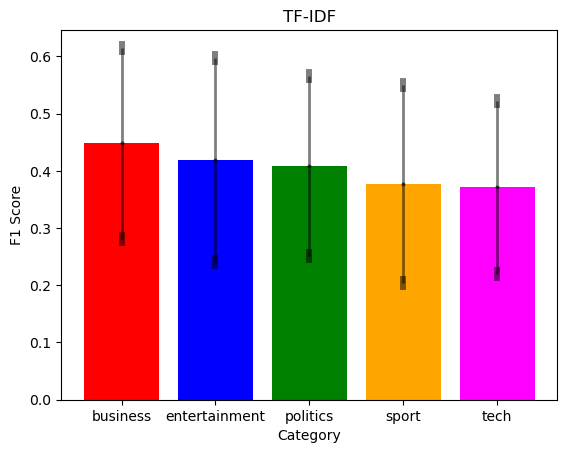

Mean average precision: 0.8268707482993197


{'mean_precision': 0.407046332046332,
 'mean_recall': 0.4366533366136944,
 'mean_f1_scores': 0.4051717424602836}

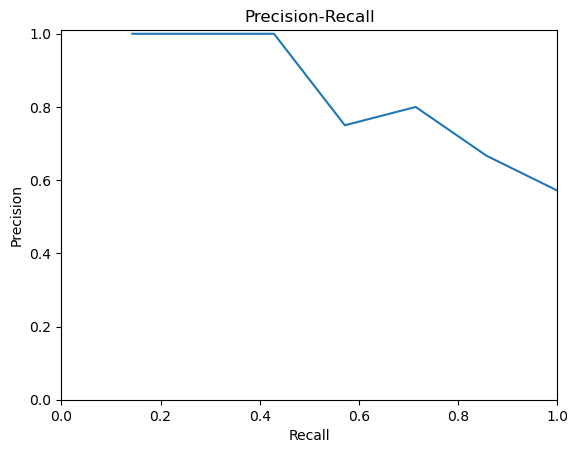

In [174]:
evaluation(categorized_summary_sentence_indices, tf_idf_extract, category_names=category_names, model_name="TF-IDF")

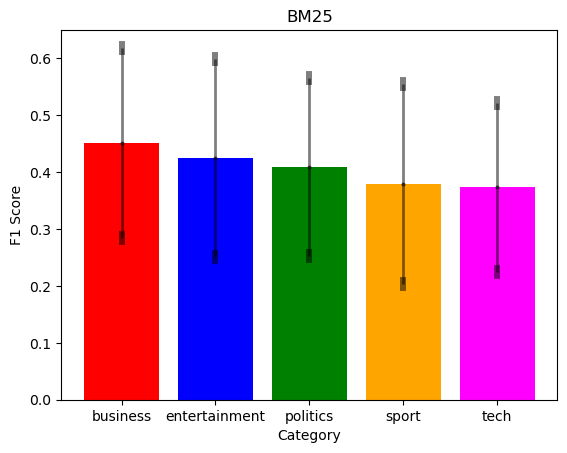

Mean average precision: 0.7506802721088435


{'mean_precision': 0.4105212355212355,
 'mean_recall': 0.43936084924554913,
 'mean_f1_scores': 0.4082343867024673}

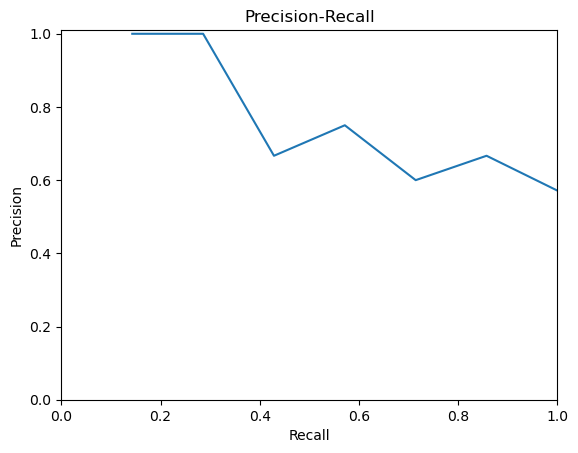

In [175]:
evaluation(categorized_summary_sentence_indices, bm25_extract, category_names=category_names, model_name="BM25")

subset for BERT comparison\
takes too long otherwise\ 

TODO: 
* evaluation + first question -> Sebastian   
* question 2, 3, 4 -> Francisco
* question 5 and 6 -> Tuna

B) **Summarization**

*B.1 Summarization solution: results for a given document*

In [ ]:
#code, statistics and/or charts here
article_id = 0
print(articles[article_id])
summarization(article_id, p=5, l=100, o="rel", I_or_D=I) 

*B.2 IR models (TF-IDF, BM25 and EBRT)*

In [ ]:
#code, statistics and/or charts here

*B.3 Reciprocal rank funsion*

In [ ]:
def get_RRF(article_id, index, collection, mu=5, p=5):
    
    #get all scores for BERT
    scores_bert = summarization(d=article_id, p=0, l=0, o="rel", I_or_D=collection, model='BERT', bert_model=bert_model, bert_tokenizer=bert_tokenizer)
    ranks_bert = {key: rank for rank, key in enumerate(scores_bert, 1)}
    #get all scores of BM25
    scores_bm25 = summarization(d=article_id, p=0, l=0, o="rel", I_or_D=index, model='BM25')
    ranks_bm25 = {key: rank for rank, key in enumerate(scores_bm25, 1)} 
    
    #get RRF
    scores_rrf = defaultdict(int)
    for sent_number in ranks_bert.keys():
        scores_rrf[sent_number] = 1/(mu + ranks_bert[sent_number]) + 1/(mu + ranks_bm25[sent_number])
        
    return sort_by_value(scores_rrf, p, reverse=True)

article_id = map_path_to_articleID(document_path)
print("ORIGINAL DOCUMENT")
print(articles[article_id])
all_scores = get_RRF (article_id, I, articles, mu=5, p=5)
all_scores = dict(sorted(all_scores.items()))
print("SUMMARY")
sentences = nltk.sent_tokenize(articles[article_id])
for sent_id, rank in all_scores.items(): 
    print(f"{rank:.2f}: {sentences[sent_id]}")

*B.4 Maximal Marginal Relevance*

# MMR 
Maximal Marginal Relevance (MRR) is a method that can be used to increase sentence diversity. 

The proposed method iteratively selects the most informative sentence according to a given IR model, adding it to the set of sentences in the summary and removing it from the document. Next sentence selection is based on the MMR score that simultaneously attempts to select sentences that are relevant and dissimilar to the sentences selected so far (non-redundancy).

In [ ]:
#code, statistics and/or charts here
summarization(10, 0, 0, 'rel', I, model='MMR-TFIDF', λ=0.5)

In [ ]:
#code, statistics and/or charts here
summarization(10, 0, 0, 'rel', I, model='MMR-TFIDF', λ=0.99)

# Question 6: Classification Metrics Over P

In [ ]:
import itertools


def get_conf_matrix_stats(article_file_paths, index, collection, summaries):
    conf_stats = []
    
    for category_id, category in enumerate(article_file_paths): 
        for path in category: 
            article_id = map_path_to_articleID(path)
            article = nltk.sent_tokenize(articles[article_id])
            
            start_time = time.time()
            
            #Calculating scores for all sentences using summarization function
            scores_bm25 = summarization(d=article_id, p=0, l=0, o="rel", I_or_D=index, model='BM25')
            scores_bm25= sort_by_value(scores_bm25, 1000, reverse=True)
            scores_tfidf = summarization(d=article_id, p=0, l=0, o="rel", I_or_D=index, model='TF-IDF')
            scores_tfidf = sort_by_value(scores_tfidf, 1000, reverse=True)

            #Now we are iterating over different p to see how our summarization results under different p
            for p in range(16):        
                if p==0:
                    continue

                #initializing tp, fp, tn, fn for the two models    
                tp_tfidf, fp_tfidf, tn_tfidf, fn_tfidf = 0, 0, 0, 0
                tp_bm25, fp_bm25, tn_bm25, fn_bm25 = 0, 0, 0, 0

                #iterating over all sentences in our articles to classify them as tp,fp,tn,fn
                for key in range(len(article)):

                    #TP, FP, TN, FN for BM-25  
                    if (key in dict(itertools.islice(scores_bm25.items(), p)).keys()) & (article[key] in summaries[article_id]):
                        tp_bm25 +=1     
                    elif (key not in dict(itertools.islice(scores_bm25.items(), p)).keys()) & (article[key] in summaries[article_id]):
                        fn_bm25 +=1
                    elif (key in dict(itertools.islice(scores_bm25.items(), p)).keys()) & (article[key] not in summaries[article_id]):
                        fp_bm25 +=1
                    else:
                        tn_bm25 +=1

                    #TP, FP, TN, FN for TF-IDF
                    if (key in dict(itertools.islice(scores_tfidf.items(), p)).keys()) & (article[key] in summaries[article_id]):
                        tp_tfidf +=1     
                    elif (key not in dict(itertools.islice(scores_tfidf.items(), p)).keys()) & (article[key] in summaries[article_id]):
                        fn_tfidf +=1
                    elif (key in dict(itertools.islice(scores_tfidf.items(), p)).keys()) & (article[key] not in summaries[article_id]):
                        fp_tfidf +=1
                    else:
                        tn_tfidf +=1 
                
                
                acc_bm25 = (tp_bm25 + tn_bm25)/ (tp_bm25 + fn_bm25 + tn_bm25 + fp_bm25)
                precision_bm25 = tp_bm25/ (tp_bm25 + fp_bm25)
                recall_bm25 = tp_bm25/ (tp_bm25 + fn_bm25)
                f1_bm25 = 0 if precision_bm25+recall_bm25==0 else 2 * (precision_bm25*recall_bm25) / (precision_bm25+recall_bm25)
                specificity_bm25 = tn_bm25/ (tn_bm25 + fp_bm25)
                
                acc_tfidf = (tp_tfidf + tn_tfidf)/ (tp_tfidf + fn_tfidf + tn_tfidf + fp_tfidf)
                precision_tfidf = tp_tfidf/ (tp_tfidf + fp_tfidf)
                recall_tfidf = tp_tfidf/ (tp_tfidf + fn_tfidf)
                f1_tfidf = 0 if precision_tfidf+recall_tfidf==0 else 2 * (precision_tfidf*recall_tfidf) / (precision_tfidf+recall_tfidf)
                specificity_tfidf = tn_tfidf/ (tn_tfidf + fp_tfidf)
                
                #append stats
                conf_stats.append({'article': article_id , 'p': p,
                                   'tp_bm25':tp_bm25, 'fn_bm25':fn_bm25, 'fp_bm25':fp_bm25, 'tn_bm25':tn_bm25,
                                   'acc_bm25':acc_bm25, 'precision_bm25':precision_bm25, 'recall_bm25':recall_bm25,
                                   'f1_bm25':f1_bm25, 'specificity_bm25':specificity_bm25,
                                   'tp_tfidf':tp_tfidf, 'fn_tfidf':fn_tfidf, 'fp_tfidf':fp_tfidf, 'tn_tfidf':tn_tfidf,
                                   'acc_tfidf':acc_tfidf, 'precision_tfidf':precision_tfidf, 'recall_tfidf':recall_tfidf,
                                   'f1_tfidf':f1_tfidf, 'specificity_tfidf':specificity_tfidf})
                #print("article:", article_id, "for", p, "-length is done!")
    #print("time spent is:", time.time() - start_time)           
    return conf_stats

In [ ]:
import pandas as pd

conf_stats_over_p = get_conf_matrix_stats(article_file_paths, I, articles, summaries)
df_art_p = pd.DataFrame.from_dict(conf_stats_over_p, orient='columns')

In [ ]:
df_art_p['acc_bm25'] = (df_art_p['tp_bm25'] + df_art_p['tn_bm25'])/ (df_art_p['tp_bm25'] + df_art_p['fn_bm25'] + df_art_p['tn_bm25'] + df_art_p['fp_bm25'])
df_art_p['precision_bm25'] = df_art_p['tp_bm25']/ (df_art_p['tp_bm25'] + df_art_p['fp_bm25'])
df_art_p['recall_bm25'] = df_art_p['tp_bm25']/ (df_art_p['tp_bm25'] + df_art_p['fn_bm25'])
df_art_p['f1_bm25'] = df_art_p.apply(lambda x: 0 if (x['precision_bm25'] + x['recall_bm25'])==0 else 2 * (x['precision_bm25']*x['recall_bm25']) / (x['precision_bm25']+x['recall_bm25']),  axis=1)
df_art_p['specificity_bm25'] = df_art_p['tn_bm25']/ (df_art_p['tn_bm25'] + df_art_p['fp_bm25'])

df_art_p['acc_tfidf'] = (df_art_p['tp_tfidf'] + df_art_p['tn_tfidf'])/ (df_art_p['tp_tfidf'] + df_art_p['fn_tfidf'] + df_art_p['tn_tfidf'] + df_art_p['fp_tfidf'])
df_art_p['precision_tfidf'] = df_art_p['tp_tfidf']/ (df_art_p['tp_tfidf'] + df_art_p['fp_tfidf'])
df_art_p['recall_tfidf'] = df_art_p['tp_tfidf']/ (df_art_p['tp_tfidf'] + df_art_p['fn_tfidf'])
df_art_p['f1_tfidf'] = df_art_p.apply(lambda x: 0 if (x['precision_tfidf'] + x['recall_tfidf'])==0 else 2 * (x['precision_tfidf']*x['recall_tfidf']) / (x['precision_tfidf']+x['recall_tfidf']),  axis=1)
df_art_p['specificity_tfidf'] = df_art_p['tn_tfidf']/ (df_art_p['tn_tfidf'] + df_art_p['fp_tfidf'])

df_art_p.plot(x='p', y=['precision_bm25', 'recall_bm25', 'f1_bm25'], title='BM-25 Performance Over The Collection',  grid=True, xticks=df_art_p['p'])
df_art_p.plot(x='p', y=['precision_tfidf', 'recall_tfidf', 'f1_tfidf'], title='TF-IDF Performance Over The Collection',  grid=True, xticks=df_art_p['p'])


C) **Keyword extraction**

In [ ]:
#code, statistics and/or charts here
article_id = 0
print(articles[article_id])
keyword_extraction(article_id, 10, I)

D) **Evaluation**

In [ ]:
#code, statistics and/or charts here

<H3>Part II: questions materials (optional)</H3>

**(1)** Corpus *D* and summaries *S* description.

In [ ]:
import statistics
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
def get_number_of_sentences(documents: list) -> list: 
    number_of_sentences = list()
    for document in documents: 
        sents = sent_tokenize(document) 
        number_of_sentences.append(len(sents))
    return number_of_sentences

In [ ]:
def get_statistics(documents: list) -> Union[float, float, float]: 
    number_of_sentences = get_number_of_sentences(documents)
    mean = statistics.mean(number_of_sentences)
    median = statistics.median(number_of_sentences)
    std = statistics.stdev(number_of_sentences)
    return mean, std, median 

In [ ]:
def plot_distribution(documents: list):
    number_of_sentences = get_number_of_sentences(documents)
    mean, std, median = get_statistics(documents)
    plt.hist(number_of_sentences, bins=80)
    plt.title(f"mean: {mean:.2f}, std: {std:.2f}, median: {median:.2f}")
    plt.xlabel("Number of sentences")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
#code, statistics and/or charts here

# average number of sentences 
mean, std, median = get_statistics(articles)
plot_distribution(articles)
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")
print(f"Median: {median}")

In [ ]:
##mean, std, median = get_statistics(summaries)
#plot_distribution(summaries)
#print(f"Mean: {mean}")
##print(f"Standard deviation: {std}")
#print(f"Median: {median}")

In [ ]:
number_of_sentences = [len(l) for l in summary_sentence_indices]
mean = statistics.mean(number_of_sentences)
median = statistics.median(number_of_sentences)
std = statistics.stdev(number_of_sentences)
plt.hist(number_of_sentences, bins=80)
plt.title(f"mean: {mean:.2f}, std: {std:.2f}, median: {median:.2f}")
plt.xlabel("Number of sentences")
plt.ylabel("Frequency")
plt.show()

**(2)** Summarization performance for the overall and category-conditional corpora.

In [ ]:
#code, statistics and/or charts here

**...** (additional questions with empirical results)

<H3>END</H3>